**Detección del estado de semáforos en imágenes urbanas**

**Objetivo:** Desarrollar un sistema capaz de detectar semáforos en imágenes urbanas y clasificar su estado como rojo, amarillo o verde, utilizando técnicas de segmentación de color y/o detección por bounding boxes.

**Librerías a utilizar**

In [ ]:
# Importamos las librerías necesarias

import numpy as np
import pandas as pd

# Manejo de imágenes
import cv2
from PIL import Image

# Visualización
import matplotlib.pyplot as plt

# Importación de librerías necesarias

# Manipulación de arrays y estructuras de datos
import numpy as np
import pandas as pd

# Procesamiento de imágenes
import cv2  # OpenCV: principal librería para visión por computadora
from PIL import Image  # PIL: útil para trabajar con imágenes en distintos formatos

# Visualización
import matplotlib.pyplot as plt  # Para mostrar imágenes y gráficos

# Sistema de archivos y manejo de rutas
import os
import glob  # Para buscar archivos por patrón (ej: *.jpg)
from glob import glob

# Utilidades varias
from IPython.display import display  # Para mostrar imágenes directamente en celdas

# Ignorar warnings innecesarios para mantener limpia la salida
import warnings
warnings.filterwarnings("ignore")



**Trabajaremos con "LISA Traffic Light Dataset"**

Generado por UCSD (University of California San Diego)

Contiene imágenes de calles urbanas, algunas de ellas con anotaciones de semáforos (bounding box)


**Obtención del dataset via kagglehub**

In [ ]:
# Instalamos kagglehub
!pip install -q kagglehub

# importamos
import kagglehub

# Descargamos el dataset LISA Traffic Light Dataset
path = kagglehub.dataset_download("mbornoe/lisa-traffic-light-dataset")

print("Dataset descargado en:", path)


Dataset descargado en: /kaggle/input/lisa-traffic-light-dataset


**Exploración del dataset**

In [ ]:
# Accedemos a los archivos y vemos las primeras carpetas dentro del dataset descargado
print(" Carpetas principales encontradas:")
print(os.listdir(path))

# Buscamos algunas imágenes JPG
imagenes = glob(os.path.join(path, '**', '*.jpg'), recursive=True)
print(f"Cantidad de imágenes encontradas: {len(imagenes)}")



 Carpetas principales encontradas:
['nightTrain', 'nightSequence1', 'daySequence1', 'Annotations', 'sample-nightClip1', 'sample-dayClip6', 'daySequence2', 'nightSequence2', 'dayTrain']
Cantidad de imágenes encontradas: 44075


📁 Subcarpetas encontradas en el directorio del dataset:
  └── nightTrain
  └── nightSequence1
  └── daySequence1
  └── Annotations
  └── sample-nightClip1
  └── sample-dayClip6
  └── daySequence2
  └── nightSequence2
  └── dayTrain

🖼️ Total de imágenes encontradas: 44075


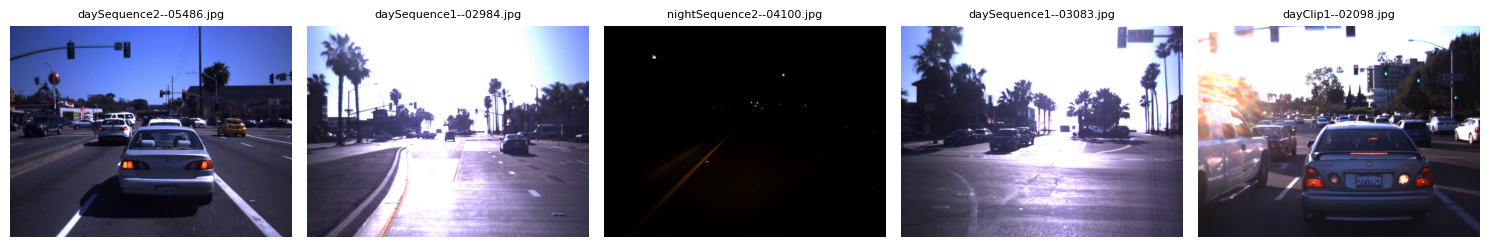

In [ ]:
# Mostrar las subcarpetas principales dentro del dataset
print("📁 Subcarpetas encontradas en el directorio del dataset:")
for folder in os.listdir(path):
    print("  └──", folder)

# Buscar todas las imágenes JPG dentro del dataset (en subcarpetas)
image_paths = glob(os.path.join(path, '**', '*.jpg'), recursive=True)
print(f"\n🖼️ Total de imágenes encontradas: {len(image_paths)}")

# Mostrar algunas imágenes aleatorias del dataset
import random

n = 5  # Número de imágenes a visualizar
sample_images = random.sample(image_paths, n)

plt.figure(figsize=(15, 5))
for i, img_path in enumerate(sample_images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, n, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


**¡IMPORTANTE!**    
Como podemos observar, el dataset contiene imágenes de transito urbano. Como nuestra intención es trabajar con las imagenes de semáforos, debemos utilizar las ***anotaciones con bounding boxes y etiquetas***  para lograrlo.

In [ ]:
# 📄 Buscamos archivos CSV o TXT con anotaciones
annotation_files = glob(os.path.join(path, '**', '*.csv'), recursive=True) + \
                   glob(os.path.join(path, '**', '*.txt'), recursive=True)

print("📑 Archivos de anotaciones encontrados:")
for f in annotation_files:
    print("  └──", f)


📑 Archivos de anotaciones encontrados:
  └── /kaggle/input/lisa-traffic-light-dataset/Annotations/Annotations/nightTrain/nightClip1/frameAnnotationsBOX.csv
  └── /kaggle/input/lisa-traffic-light-dataset/Annotations/Annotations/nightTrain/nightClip1/frameAnnotationsBULB.csv
  └── /kaggle/input/lisa-traffic-light-dataset/Annotations/Annotations/nightTrain/nightClip4/frameAnnotationsBOX.csv
  └── /kaggle/input/lisa-traffic-light-dataset/Annotations/Annotations/nightTrain/nightClip4/frameAnnotationsBULB.csv
  └── /kaggle/input/lisa-traffic-light-dataset/Annotations/Annotations/nightTrain/nightClip3/frameAnnotationsBOX.csv
  └── /kaggle/input/lisa-traffic-light-dataset/Annotations/Annotations/nightTrain/nightClip3/frameAnnotationsBULB.csv
  └── /kaggle/input/lisa-traffic-light-dataset/Annotations/Annotations/nightTrain/nightClip2/frameAnnotationsBOX.csv
  └── /kaggle/input/lisa-traffic-light-dataset/Annotations/Annotations/nightTrain/nightClip2/frameAnnotationsBULB.csv
  └── /kaggle/input/l

**Leemos un archivo que contiene las bounding boxes (coordenadas del semáforo dentro de la imagen)**

In [ ]:

# Ruta al archivo de anotaciones con bounding boxes
annotation_path = os.path.join(
    path,
    "sample-dayClip6/sample-dayClip6/frameAnnotationsBOX.csv"
)

# Leemos el archivo CSV con delimitador de punto y coma (;)
df_annotations = pd.read_csv(annotation_path, sep=';')

# Mostramos las primeras filas para ver la estructura
print("📋 Columnas del archivo de anotaciones:")
print(df_annotations.columns.tolist())
df_annotations.head()


📋 Columnas del archivo de anotaciones:
['Filename', 'Annotation tag', 'Upper left corner X', 'Upper left corner Y', 'Lower right corner X', 'Lower right corner Y', 'Origin file', 'Origin frame number', 'Origin track', 'Origin track frame number']


Filename Annotation tag  Upper left corner X  \
0  dayTraining/dayClip6--00000.jpg           stop                  506   
1  dayTraining/dayClip6--00000.jpg       stopLeft                  595   
2  dayTraining/dayClip6--00001.jpg           stop                  504   
3  dayTraining/dayClip6--00001.jpg       stopLeft                  591   
4  dayTraining/dayClip6--00002.jpg           stop                  500   

   Upper left corner Y  Lower right corner X  Lower right corner Y  \
0                  354                   518                   372   
1                  423                   613                   454   
2                  352                   516                   370   
3                  424                   612                   446   
4                  346                   512                   364   

                                         Origin file  Origin frame number  \
0  dayTraining/dayClip6/dayClip6Shutter0.000200-G...                    0   
1  dayTraining/dayClip6/dayClip6Shutter0.000200-G...                    0   
2  dayTraining/dayClip6/dayClip6Shutter0.000200-G...                    1   
3  dayTraining/dayClip6/dayClip6Shutter0.000200-G...                    1   
4  dayTraining/dayClip6/dayClip6Shutter0.000200-G...                    2   

                                        Origin track  \
0  dayTraining/dayClip6/dayClip6Shutter0.000200-G...   
1  dayTraining/dayClip6/dayClip6Shutter0.000200-G...   
2  dayTraining/dayClip6/dayClip6Shutter0.000200-G...   
3  dayTraining/dayClip6/dayClip6Shutter0.000200-G...   
4  dayTraining/dayClip6/dayClip6Shutter0.000200-G...   

   Origin track frame number  
0                          0  
1                          0  
2                          1  
3                          1  
4                          2

In [ ]:
# 🛠️ Reconstruir el DataFrame con rutas válidas a partir de coincidencias reales

# Creamos un diccionario que mapea nombre de archivo → ruta completa
archivo_a_ruta = {os.path.basename(p): p for p in glob(os.path.join(path, '**', '*.jpg'), recursive=True)}

# Creamos una nueva columna 'image_path' que usa esa correspondencia
df_annotations['image_path'] = df_annotations['Filename'].apply(lambda x: archivo_a_ruta.get(os.path.basename(x.strip()), None))

# Mostramos algunas filas con ruta válida
print("🔗 Primeras rutas válidas reconstruidas:")
df_annotations[['Filename', 'image_path']].head()


🔗 Primeras rutas válidas reconstruidas:


Filename  \
0  dayTraining/dayClip6--00000.jpg   
1  dayTraining/dayClip6--00000.jpg   
2  dayTraining/dayClip6--00001.jpg   
3  dayTraining/dayClip6--00001.jpg   
4  dayTraining/dayClip6--00002.jpg   

                                          image_path  
0  /kaggle/input/lisa-traffic-light-dataset/dayTr...  
1  /kaggle/input/lisa-traffic-light-dataset/dayTr...  
2  /kaggle/input/lisa-traffic-light-dataset/dayTr...  
3  /kaggle/input/lisa-traffic-light-dataset/dayTr...  
4  /kaggle/input/lisa-traffic-light-dataset/dayTr...

**Dibujamos la bounding box o coordenadas del semáforo sobre una imagen**

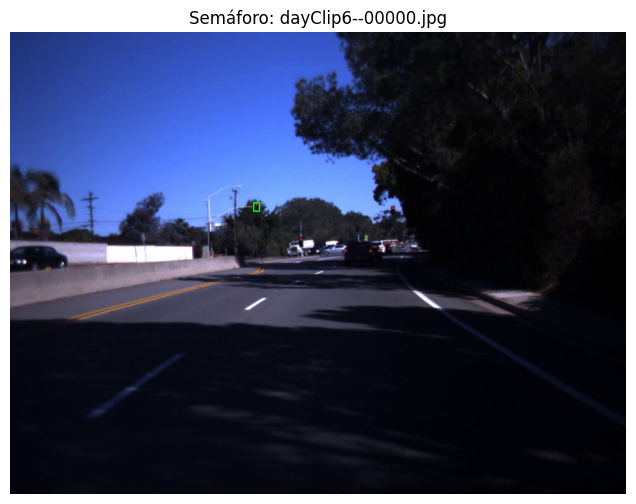

In [ ]:
# Mostramos la primera imagen válida con su bounding box usando la nueva columna

# Filtramos las filas con rutas válidas
df_valid = df_annotations[df_annotations['image_path'].notnull()]

# Verificamos si hay al menos una imagen válida
if df_valid.empty:
    print("❌ No se encontraron imágenes válidas en el DataFrame.")
else:
    # Tomamos la primera fila válida
    row = df_valid.iloc[0]
    image_path = row['image_path']

    # Leemos la imagen
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Bounding box
    x1, y1 = int(row['Upper left corner X']), int(row['Upper left corner Y'])
    x2, y2 = int(row['Lower right corner X']), int(row['Lower right corner Y'])

    # Dibujar la caja sobre la imagen
    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

    # Mostrar la imagen con la caja
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.title(f"Semáforo: {os.path.basename(row['Filename'].strip())}")
    plt.axis('off')
    plt.show()


**Extraemos y visualizamos el ROI (semáforo) en HSV**

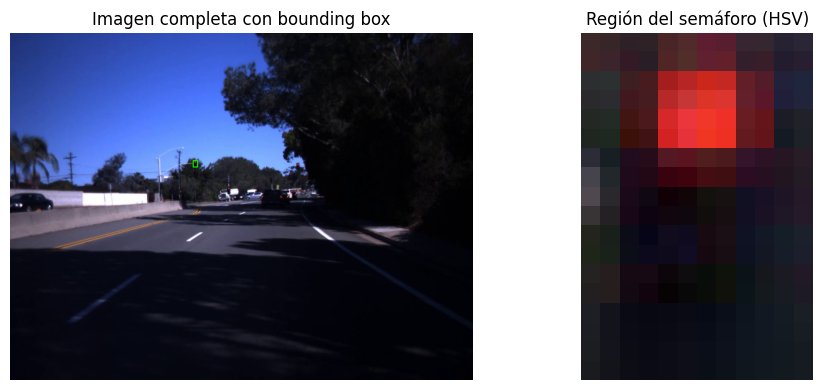

In [ ]:
# Usamos la misma fila que vimos antes (puede adaptarse a un bucle luego)
row = df_valid.iloc[0]
image_path = row['image_path']

# Cargamos la imagen completa
img_bgr = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Extraemos coordenadas del bounding box
x1, y1 = int(row['Upper left corner X']), int(row['Upper left corner Y'])
x2, y2 = int(row['Lower right corner X']), int(row['Lower right corner Y'])

# Dibujamos la bounding box sobre la imagen RGB
img_boxed = img_rgb.copy()
cv2.rectangle(img_boxed, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

# Extraemos el ROI (región de interés)
roi = img_bgr[y1:y2, x1:x2]  # ¡En BGR, porque vamos a convertirlo a HSV!

# Convertimos el ROI a HSV
roi_hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# Mostramos la imagen original + el ROI
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_boxed)
plt.title("Imagen completa con bounding box")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(roi_hsv, cv2.COLOR_HSV2RGB))  # HSV convertido a RGB para visualizar
plt.title("Región del semáforo (HSV)")
plt.axis('off')

plt.tight_layout()
plt.show()


**Observamos que el semáforo se ve pixelado en el recorte. Esto sucede porque, aunque el dataset tiene imagenes de alta resolución, no todas tienen a los semaforos ceracnos y con una buena cantidad de pixeles.**

**Filtramos las  anotaciones con bounding boxes grandes (semáforos más cercanos)Probamos como valor mínimo 50 pixeles**

✅ Anotaciones con bounding box >= 50px: 105


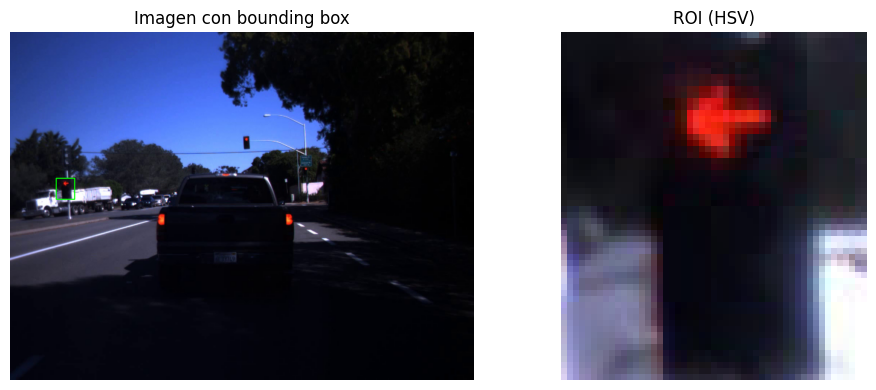

In [ ]:
# Calculamos ancho y alto del bounding box para cada fila
df_annotations['bbox_width'] = df_annotations['Lower right corner X'] - df_annotations['Upper left corner X']
df_annotations['bbox_height'] = df_annotations['Lower right corner Y'] - df_annotations['Upper left corner Y']

# Definimos un umbral mínimo de tamaño (puede ajustarse)
min_size = 50  # píxeles

# Filtramos filas con rutas válidas y bounding boxes suficientemente grandes
df_filtered = df_annotations[
    df_annotations['image_path'].notnull() &
    (df_annotations['bbox_width'] >= min_size) &
    (df_annotations['bbox_height'] >= min_size)
].copy()

# Mostramos cuántas anotaciones cumplen esta condición
print(f"✅ Anotaciones con bounding box >= {min_size}px: {len(df_filtered)}")

# Si hay resultados, mostramos una de ellas
if not df_filtered.empty:
    row = df_filtered.iloc[0]
    image_path = row['image_path']

    # Cargar imagen y recorte
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    x1, y1 = int(row['Upper left corner X']), int(row['Upper left corner Y'])
    x2, y2 = int(row['Lower right corner X']), int(row['Lower right corner Y'])

    # ROI y HSV
    roi = img_bgr[y1:y2, x1:x2]
    roi_hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Mostrar imagen y ROI
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
    plt.imshow(img_rgb)
    plt.title("Imagen con bounding box")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(roi_hsv, cv2.COLOR_HSV2RGB))
    plt.title("ROI (HSV)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("❌ No se encontraron semáforos con tamaño mínimo definido.")


**Concluimos que, tanto en imagenes lejanas como en las que tienen mas de 50 pixeles, las luces se detectan claramente. Al tener que detectar solamente el color dominante, la tarea se vuelve mas tolerable al tamaño y la distancia**

**Detección de color en ROI**

Vamos a detectar la luz que marca el semáforo dentro del ROI usando segmentación por color en espacio HSV.

In [ ]:
# Función para detectar automaticamente el color del semáforo en el ROI (región recortada)
def detectar_color_semaforo(roi_bgr):
    # Convertimos el ROI a HSV
    hsv = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2HSV)

    # Rango para ROJO (es especial, porque se cruza el 0 en el círculo HSV)
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 100, 100])
    upper_red2 = np.array([179, 255, 255])

    # Rango para AMARILLO
    lower_yellow = np.array([15, 100, 100])
    upper_yellow = np.array([35, 255, 255])

    # Rango para VERDE
    lower_green = np.array([40, 100, 100])
    upper_green = np.array([90, 255, 255])

    # Máscaras binarias
    mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask_red = cv2.bitwise_or(mask_red1, mask_red2)

    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    # Contamos píxeles por color
    red_count = np.sum(mask_red > 0)
    yellow_count = np.sum(mask_yellow > 0)
    green_count = np.sum(mask_green > 0)

    # Diccionario para comparar
    conteos = {
        "Rojo 🔴": red_count,
        "Amarillo 🟡": yellow_count,
        "Verde 🟢": green_count
    }

    # Obtenemos el color dominante
    color_dominante = max(conteos, key=conteos.get)

    return color_dominante, conteos

# Probamos con la misma ROI que recortamos antes
roi_actual = roi  # viene del bloque anterior
color, detalle = detectar_color_semaforo(roi_actual)

# Mostramos resultados
print("🎨 Color dominante detectado:", color)
print("📊 Conteo de píxeles por color:", detalle)


🎨 Color dominante detectado: Rojo 🔴
📊 Conteo de píxeles por color: {'Rojo 🔴': np.int64(101), 'Amarillo 🟡': np.int64(0), 'Verde 🟢': np.int64(0)}


**Procesamos varias imágenes del DataFrame**

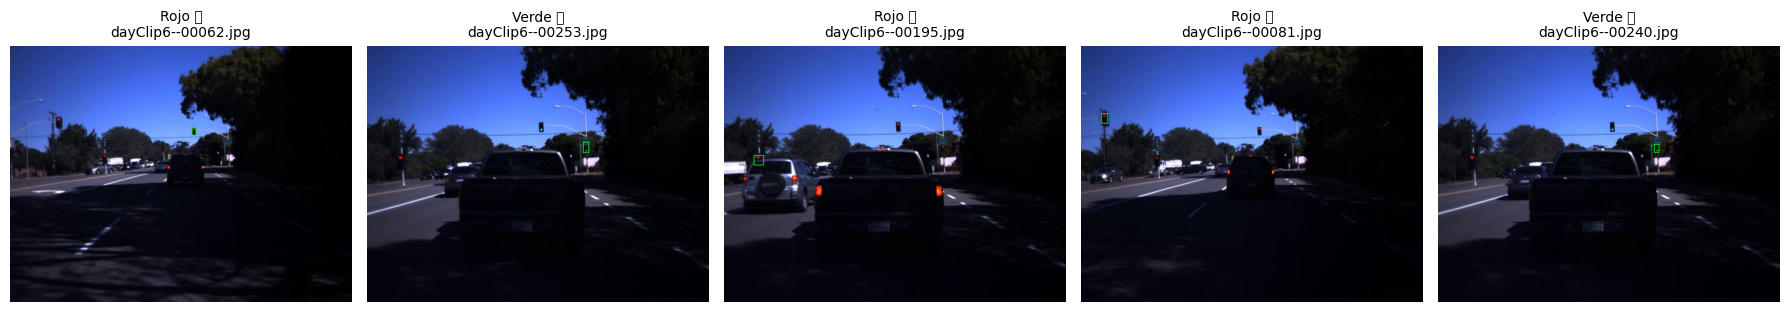

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Filtrar imágenes con ruta válida
df_valid = df_annotations[df_annotations['image_path'].notnull()].copy()

# Número de imágenes a mostrar (máximo 5)
n = min(5, df_valid.shape[0])

# Muestrear imágenes sin agrupar
ejemplos = df_valid.sample(n=n, random_state=42)

fig, axes = plt.subplots(1, n, figsize=(18, 5))
if n == 1:
    axes = [axes]

for i, (_, row) in enumerate(ejemplos.iterrows()):
    image_path = row['image_path']
    x1, y1 = int(row['Upper left corner X']), int(row['Upper left corner Y'])
    x2, y2 = int(row['Lower right corner X']), int(row['Lower right corner Y'])

    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"No se pudo leer la imagen {image_path}")
        continue
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    roi_bgr = img_bgr[y1:y2, x1:x2]

    color_detectado, _ = detectar_color_semaforo(roi_bgr)

    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)

    axes[i].imshow(img_rgb)
    axes[i].set_title(f"{color_detectado}\n{os.path.basename(image_path)}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Podemos ver varias imagenes aleatorias y detectar los distintos colores de luces. Sin embargo, observamos que son tdas de la misma secuencia

In [ ]:
# Verificar cuántas anotaciones tienen ruta de imagen
df_valid = df_annotations[df_annotations['image_path'].notnull()].copy()

print(f"🔍 Total de anotaciones con imagen válida: {len(df_valid)}")


🔍 Total de anotaciones con imagen válida: 1152


In [ ]:
imagenes_unicas = df_valid['image_path'].nunique()
print(f"🖼️ Imágenes únicas con anotaciones: {imagenes_unicas}")


🖼️ Imágenes únicas con anotaciones: 411


In [ ]:
import re

# Extraer clip_id desde el nombre del archivo
df_annotations['clip_id'] = df_annotations['Filename'].apply(
    lambda x: re.search(r'dayClip\d+', x).group(0) if re.search(r'dayClip\d+', x) else "sin_clip"
)


Despues de revisar el dataset obtenemos que:
 - Tiene 1152 anotaciones válidas.
 - Corresponden a solo 411 imágenes únicas.
 - Todas esas imágenes provienen del mismo clip: dayClip6.

Por eso, **aunque mostremos imágenes aleatorias, siempre son de la misma secuencia.**

**Vamos a probar una detección automática de semáforos basada en color, sin usar anotaciones**

In [ ]:
# Función para detectar color dominante en una región
import numpy as np

def detectar_color_semaforo_por_color_dominante(roi_bgr):
    """
    Detecta si el color dominante del ROI es rojo, amarillo o verde.
    Devuelve: nombre del color, máscara binaria
    """
    hsv = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2HSV)

    # Rangos en HSV para cada color
    rojo_bajo1 = np.array([0, 70, 50])
    rojo_alto1 = np.array([10, 255, 255])
    rojo_bajo2 = np.array([170, 70, 50])
    rojo_alto2 = np.array([180, 255, 255])

    amarillo_bajo = np.array([15, 70, 50])
    amarillo_alto = np.array([35, 255, 255])

    verde_bajo = np.array([40, 70, 50])
    verde_alto = np.array([90, 255, 255])

    # Crear máscaras
    mask_rojo = cv2.inRange(hsv, rojo_bajo1, rojo_alto1) | cv2.inRange(hsv, rojo_bajo2, rojo_alto2)
    mask_amarillo = cv2.inRange(hsv, amarillo_bajo, amarillo_alto)
    mask_verde = cv2.inRange(hsv, verde_bajo, verde_alto)

    # Contar píxeles
    suma = {
        'rojo': np.sum(mask_rojo),
        'amarillo': np.sum(mask_amarillo),
        'verde': np.sum(mask_verde)
    }

    color_detectado = max(suma, key=suma.get)
    return color_detectado, suma


**Mostramos imágenes aleatorias y buscamos el color del semaforo**

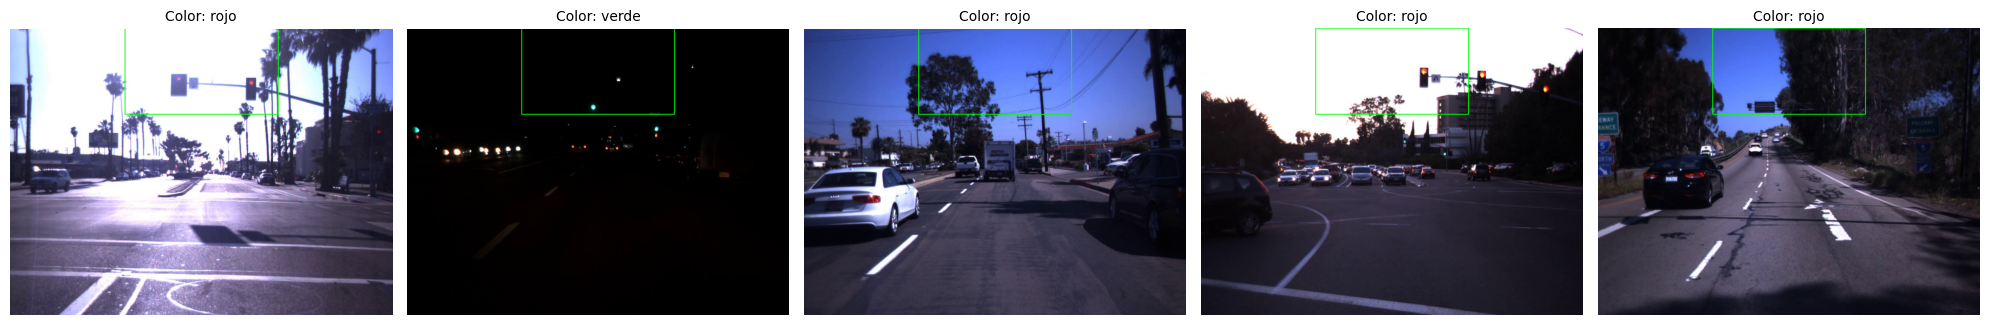

In [ ]:
import random
import matplotlib.pyplot as plt

# Tomar 5 imágenes aleatorias del dataset
muestras = random.sample(image_paths, 5)

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, path in enumerate(muestras):
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        print(f"No se pudo leer: {path}")
        continue

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w, _ = img_bgr.shape

    # Suposición: semáforo está en una zona pequeña superior
    roi_bgr = img_bgr[0:int(h*0.3), int(w*0.3):int(w*0.7)]  # recorte horizontal central y alto

    color, info = detectar_color_semaforo_por_color_dominante(roi_bgr)

    # Dibujar rectángulo en la imagen original para indicar ROI
    cv2.rectangle(img_rgb, (int(w*0.3), 0), (int(w*0.7), int(h*0.3)), (0, 255, 0), 2)

    axes[i].imshow(img_rgb)
    axes[i].set_title(f"Color: {color}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Este método usa rangos HSV robustos para detectar colores de luces de semáforo,centrandose en la parte superior de la imagen (donde normalmente aparecen semáforos) y aplicando detección de color.
Sin embargo, observamos que tiene muy baja efectividad


Probaremos un codigo que analiza toda la imagen y busca regiones que tengan colores compatibles con luces de semáforo (rojo, amarillo, verde), usa contornos para detectar esas regiones y filtra por tamaño y posición (para evitar falsas detecciones)


In [ ]:
def detectar_semaforos_por_color(img_bgr):
    """
    Detecta regiones con color de semáforo (rojo, amarillo, verde)
    y devuelve la imagen con bounding boxes y los colores detectados.
    """
    # Convertimos a HSV
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # Rango de colores en HSV
    rojo1 = cv2.inRange(hsv, np.array([0, 70, 50]), np.array([10, 255, 255]))
    rojo2 = cv2.inRange(hsv, np.array([170, 70, 50]), np.array([180, 255, 255]))
    rojo = cv2.bitwise_or(rojo1, rojo2)

    amarillo = cv2.inRange(hsv, np.array([15, 70, 50]), np.array([35, 255, 255]))
    verde = cv2.inRange(hsv, np.array([40, 70, 50]), np.array([90, 255, 255]))

    # Unimos todas las máscaras
    mascara_total = cv2.bitwise_or(cv2.bitwise_or(rojo, amarillo), verde)

    # Encontrar contornos de las regiones coloreadas
    contornos, _ = cv2.findContours(mascara_total, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    resultados = []
    img_out = img_bgr.copy()

    for cnt in contornos:
        x, y, w, h = cv2.boundingRect(cnt)

        # Filtro por tamaño mínimo y proporción razonable (relación altura/ancho)
        if w < 5 or h < 5 or w > 100 or h > 100:
            continue
        aspect_ratio = h / float(w)
        if aspect_ratio < 0.8 or aspect_ratio > 2.5:
            continue

        # Recortamos ROI
        roi_bgr = img_bgr[y:y+h, x:x+w]

        # Detectamos color dominante en el ROI
        color, _ = detectar_color_semaforo_por_color_dominante(roi_bgr)

        # Dibujamos la caja
        cv2.rectangle(img_out, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(img_out, color, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        resultados.append((x, y, w, h, color))

    return img_out, resultados


Lo probamos en una imagen aleatoria

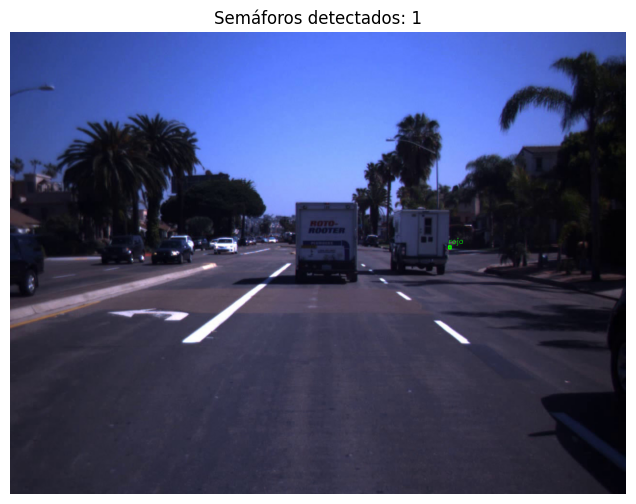

🔲 Semáforo 1: Pos=(911,444), Tamaño=(5x6), Color detectado=rojo


In [ ]:
# Elegimos una imagen aleatoria sin anotaciones
ejemplo_path = random.choice(image_paths)
img_bgr = cv2.imread(ejemplo_path)

# Detectamos semáforos
resultado_img, info = detectar_semaforos_por_color(img_bgr)

# Mostramos resultados
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(resultado_img, cv2.COLOR_BGR2RGB))
plt.title(f"Semáforos detectados: {len(info)}")
plt.axis('off')
plt.show()

# Opcional: ver datos
for i, (x, y, w, h, color) in enumerate(info):
    print(f"🔲 Semáforo {i+1}: Pos=({x},{y}), Tamaño=({w}x{h}), Color detectado={color}")


Después de probar con varias imágenes, observamos que detecta semáforos, pero tambien luces de autos.

Probaremos ajustar y que detecte solo aquellas que estan en la parte superior de la imagen

In [ ]:
def detectar_semaforos_por_color(img_bgr):
    """
    Detecta regiones con color de semáforo (rojo, amarillo, verde)
    y devuelve la imagen con bounding boxes y los colores detectados.
    Aplica filtro de ubicación vertical para reducir falsos positivos.
    """
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # Rango de colores
    rojo1 = cv2.inRange(hsv, np.array([0, 70, 50]), np.array([10, 255, 255]))
    rojo2 = cv2.inRange(hsv, np.array([170, 70, 50]), np.array([180, 255, 255]))
    rojo = cv2.bitwise_or(rojo1, rojo2)

    amarillo = cv2.inRange(hsv, np.array([15, 70, 50]), np.array([35, 255, 255]))
    verde = cv2.inRange(hsv, np.array([40, 70, 50]), np.array([90, 255, 255]))

    # Máscara combinada
    mascara_total = cv2.bitwise_or(cv2.bitwise_or(rojo, amarillo), verde)

    # Contornos
    contornos, _ = cv2.findContours(mascara_total, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    img_out = img_bgr.copy()
    resultados = []

    h_img = img_bgr.shape[0]  # Altura de la imagen

    for cnt in contornos:
        x, y, w, h = cv2.boundingRect(cnt)

        # Filtros por tamaño
        if w < 5 or h < 5 or w > 100 or h > 100:
            continue

        # Filtro por proporción
        aspect_ratio = h / float(w)
        if aspect_ratio < 0.8 or aspect_ratio > 2.5:
            continue

        # 📏 Filtro por ubicación vertical: solo regiones en el 40% superior
        if y > h_img * 0.4:
            continue

        # Recortamos el ROI
        roi_bgr = img_bgr[y:y+h, x:x+w]

        # Detectamos el color
        color, _ = detectar_color_semaforo_por_color_dominante(roi_bgr)

        # Dibujamos la caja
        cv2.rectangle(img_out, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(img_out, color, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        resultados.append((x, y, w, h, color))

    return img_out, resultados


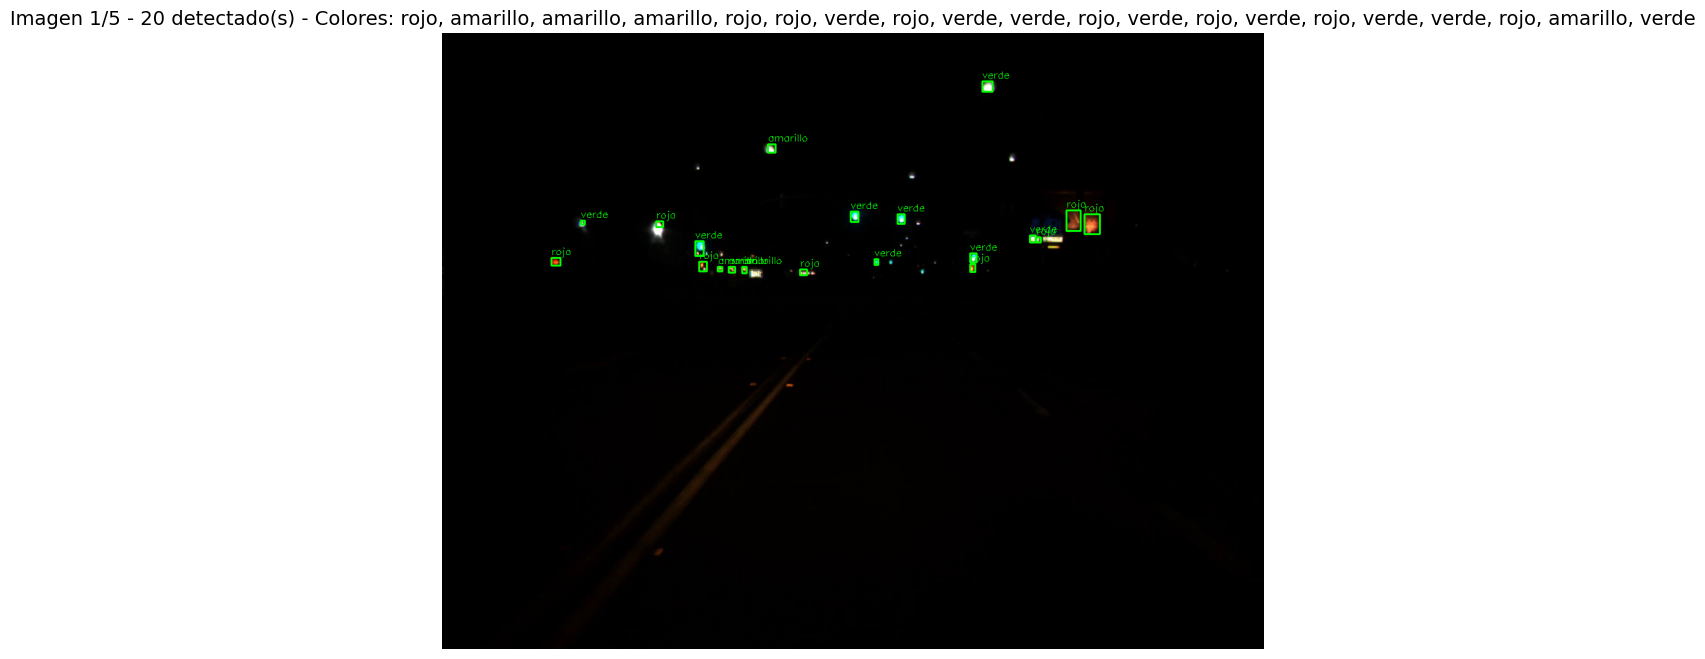

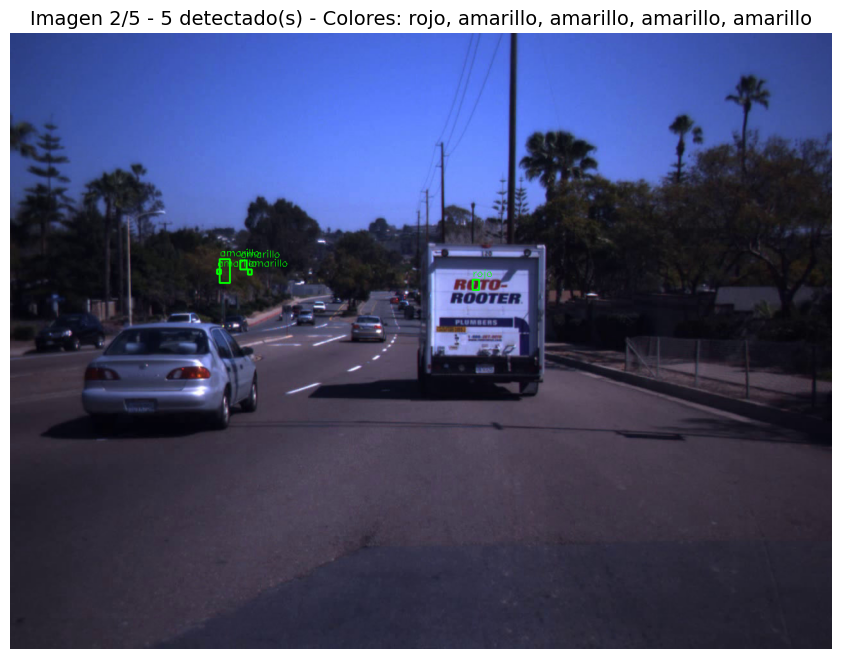

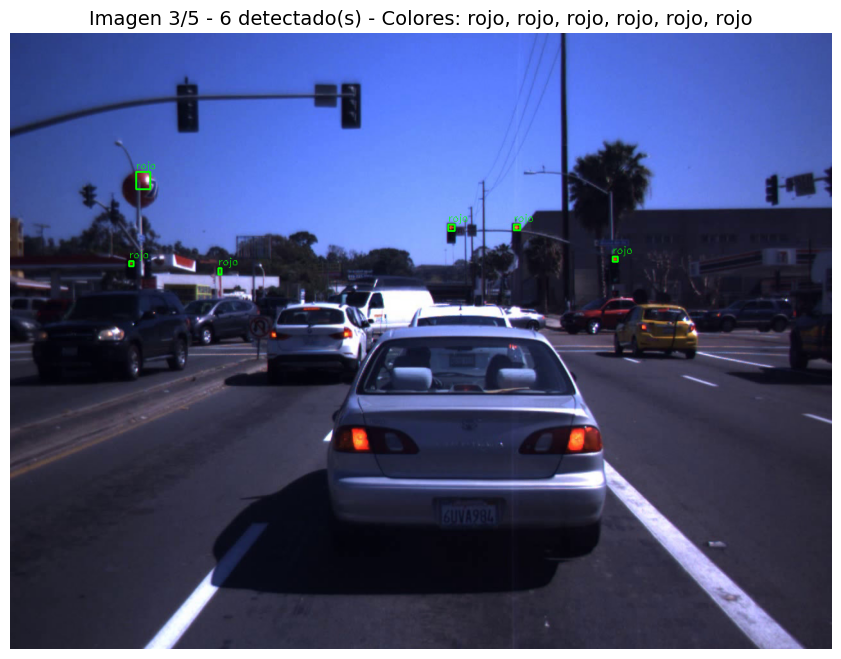

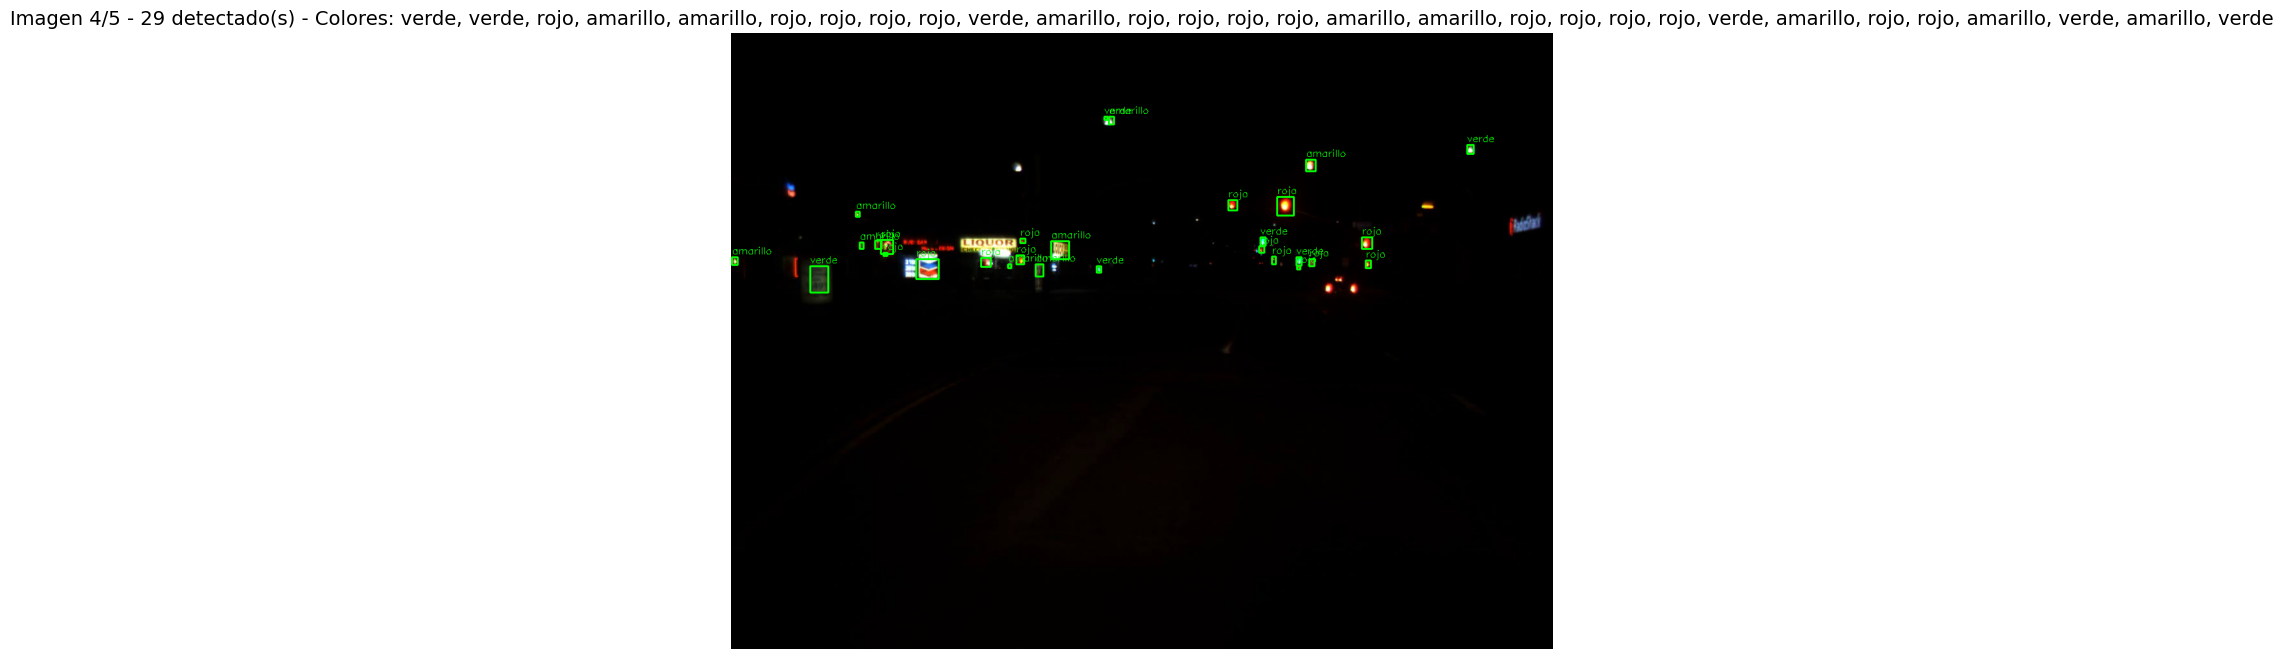

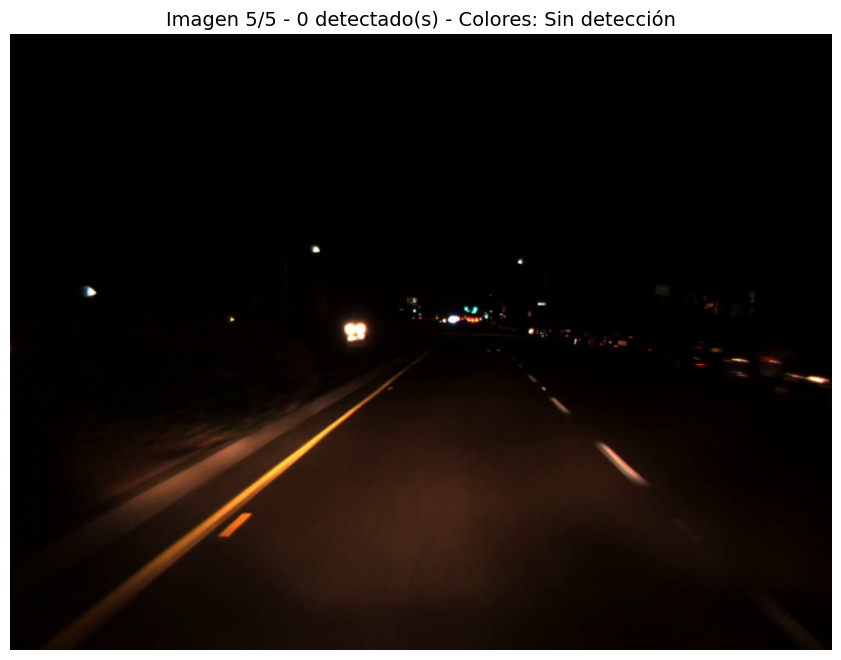

In [ ]:
# 🔢 Número de imágenes aleatorias a mostrar (una por una)
n = 5

# Seleccionamos imágenes aleatorias
muestras = random.sample(image_paths, n)

for i, path in enumerate(muestras):
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        print(f"❌ No se pudo leer: {path}")
        continue

    # Detección de semáforos
    img_detectada, detecciones = detectar_semaforos_por_color(img_bgr)

    # Resumen de colores detectados
    colores_detectados = [d[4] for d in detecciones]
    resumen = ", ".join(colores_detectados) if colores_detectados else "Sin detección"

    # Mostrar imagen
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(img_detectada, cv2.COLOR_BGR2RGB))
    plt.title(f"Imagen {i+1}/{n} - {len(detecciones)} detectado(s) - Colores: {resumen}", fontsize=14)
    plt.axis('off')
    plt.show()


# Nueva sección

**Creamos un dataframe que toma 20 imagenes y nos cuenta si detecto  algún semafoo y qué color predomina**

In [ ]:
# 🔢 Número de imágenes a analizar
n = 20

# Selección aleatoria
muestras = random.sample(image_paths, n)

# Lista de resultados
resumen_simple = []

for path in muestras:
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        print(f"❌ No se pudo leer: {path}")
        continue

    # Detección
    _, detecciones = detectar_semaforos_por_color(img_bgr)

    # Colores encontrados
    colores = [d[4] for d in detecciones]
    tiene = "sí" if colores else "no"
    color_principal = max(set(colores), key=colores.count) if colores else "ninguno"

    resumen_simple.append({
        'filename': os.path.basename(path),
        'tiene_semaforo': tiene,
        'color_detectado': color_principal
    })

# Convertimos a DataFrame
df_simple = pd.DataFrame(resumen_simple)

# Mostramos el resumen
print("📄 Resumen simplificado:")
df_simple.head(n)


📄 Resumen simplificado:


filename tiene_semaforo color_detectado
0         dayClip9--00432.jpg             sí            rojo
1         dayClip9--00800.jpg             sí            rojo
2     daySequence2--02877.jpg             sí            rojo
3       nightClip2--01834.jpg             sí            rojo
4         dayClip7--01539.jpg             sí            rojo
5     daySequence2--04698.jpg             sí        amarillo
6   nightSequence1--04893.jpg             sí        amarillo
7     daySequence2--01877.jpg             sí            rojo
8   nightSequence1--00554.jpg             sí           verde
9         dayClip7--02395.jpg             sí           verde
10    daySequence1--01636.jpg             no         ninguno
11       dayClip12--00052.jpg             sí            rojo
12        dayClip7--01052.jpg             sí            rojo
13        dayClip7--00798.jpg             sí            rojo
14        dayClip9--00331.jpg             sí            rojo
15        dayClip9--00077.jpg             sí            rojo
16    daySequence2--04849.jpg             sí            rojo
17       dayClip13--00219.jpg             no         ninguno
18      nightClip2--00208.jpg             sí        amarillo
19        dayClip1--00083.jpg             sí            rojo

Esta aproximación resultó interesante desde el punto de vista conceptual, ya que permitía trabajar sin anotaciones previas ni modelos entrenados. Sin embargo, en la práctica, mostró limitaciones en precisión, especialmente en escenas urbanas complejas, con variaciones de iluminación y presencia de luces de vehículos que generaban falsos positivos.

Ante esta situación, **decidimos probar una alternativa basada en YOLOv8, un modelo de detección de objetos preentrenado sobre COCO**(Common Objects in Context), un dataset abierto y estandarizado utilizado en visión por computadora para entrenar y evaluar modelos de detección, segmentación y reconocimiento de objetos.


In [ ]:
# Instalar ultralytics si no lo tenés
!pip install -q ultralytics

# Importar YOLO
from ultralytics import YOLO

# Cargar el modelo preentrenado YOLOv8 (nano, más rápido)
model = YOLO('yolov8n.pt')  # También podés probar con 'yolov8s.pt' o 'yolov8m.pt'

In [ ]:
# Seleccionamos 5 imágenes aleatorias de tu dataset
muestras = random.sample(image_paths, 5)

# Detección y visualización
for i, img_path in enumerate(muestras):
    img = cv2.imread(img_path)
    if img is None:
        print(f"❌ No se pudo leer: {img_path}")
        continue

    height, width = img.shape[:2]

    # Realizamos la detección
    results = model(img)

    # Procesamos resultados
    for result in results:
        boxes = result.boxes
        for box in boxes:
            if int(box.cls) == 9:  # Clase 9 = traffic light en COCO
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                conf = float(box.conf[0])

                # Dibujamos la caja
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img, f'Traffic Light {conf:.2f}', (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Mostramos la imagen
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Imagen {i+1}: {os.path.basename(img_path)}')
    plt.axis('off')
    plt.show()


NameError: name 'random' is not defined

Observamos que es interesante como funciona y para observar mejor, **pediremos que muestre 5 imagenes aleatorias en las que detecte semáforo**

Para esto, tomamos imágenes aleatorias de image_paths, las vamos procesando una por una y guardamos solo las que tengan detección de semaforo (clase 9).

Cuando tenemos 5 imágenes válidas, las mostramos y le pedimos que diga que color detectó





0: 480x640 1 truck, 180.5ms
Speed: 5.4ms preprocess, 180.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 cars, 4 traffic lights, 172.4ms
Speed: 4.6ms preprocess, 172.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 bus, 4 traffic lights, 178.6ms
Speed: 3.8ms preprocess, 178.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 traffic lights, 167.1ms
Speed: 3.8ms preprocess, 167.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 5 traffic lights, 169.4ms
Speed: 4.3ms preprocess, 169.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 4 traffic lights, 171.4ms
Speed: 3.6ms preprocess, 171.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


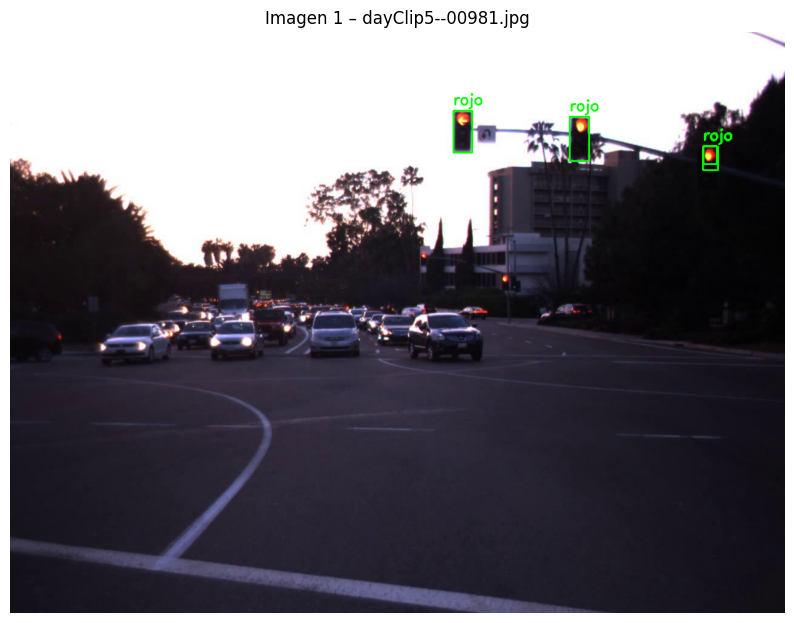

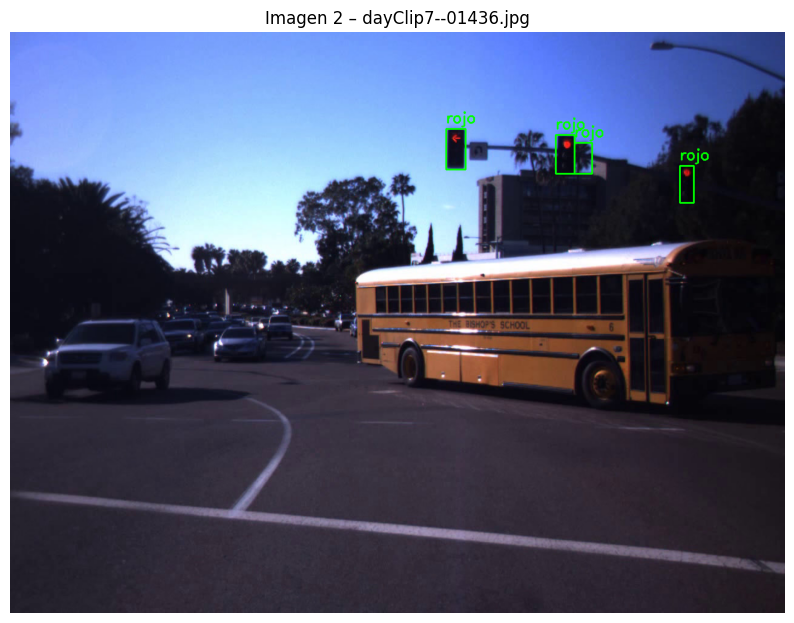

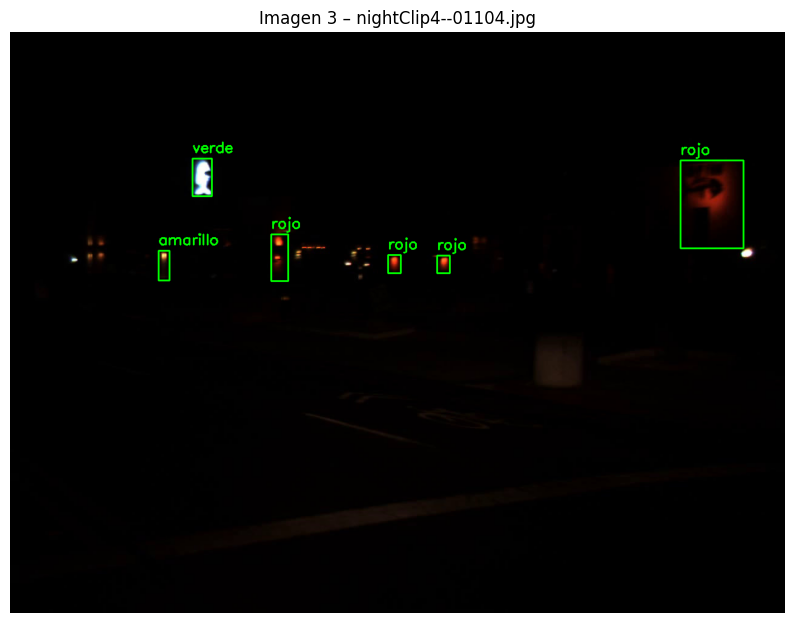

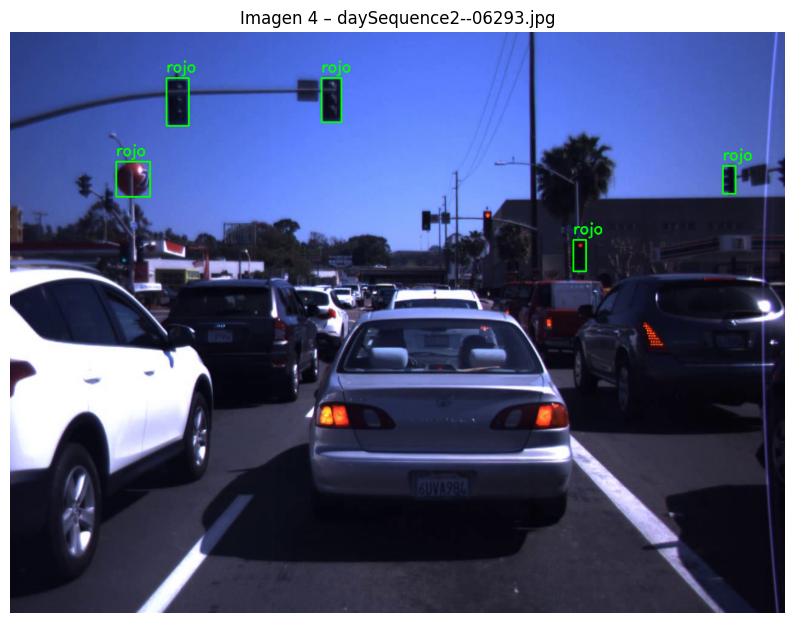

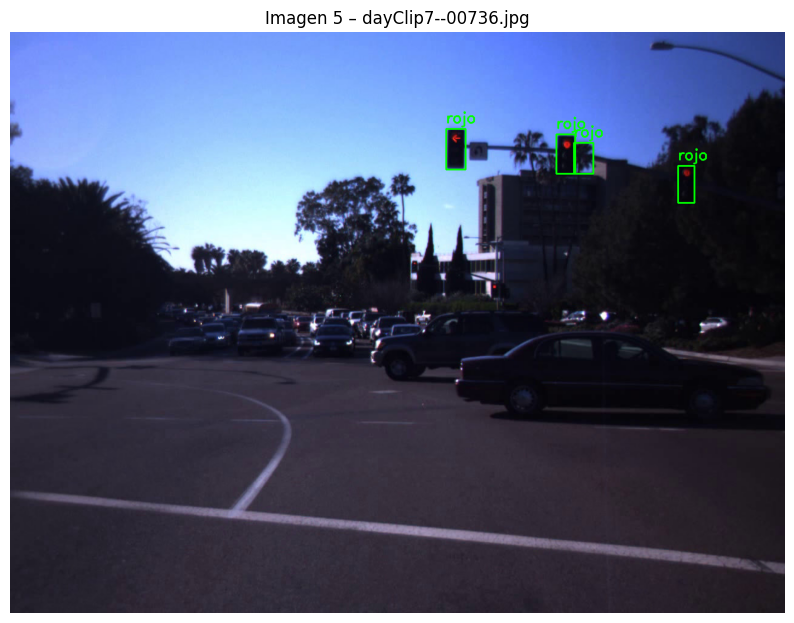

In [ ]:
# detectar_color_semaforo_por_color_dominante(roi_bgr)

imagenes_validas = []
n_deseadas = 5
revisadas = set()

while len(imagenes_validas) < n_deseadas:
    path = random.choice(image_paths)
    if path in revisadas:
        continue
    revisadas.add(path)

    img_bgr = cv2.imread(path)
    if img_bgr is None:
        continue

    results = model(img_bgr)
    detecciones = []

    for result in results:
        for box in result.boxes:
            if int(box.cls) == 9:  # Clase 9 = semáforo
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                roi_bgr = img_bgr[y1:y2, x1:x2]

                # Verificamos que el ROI tenga tamaño válido
                if roi_bgr.shape[0] < 5 or roi_bgr.shape[1] < 5:
                    continue

                # Detectamos el color del semáforo
                color, _ = detectar_color_semaforo_por_color_dominante(roi_bgr)

                # Guardamos la detección
                detecciones.append((x1, y1, x2, y2, color))

    if detecciones:
        imagenes_validas.append((img_bgr, path, detecciones))

# Mostramos las imágenes con bounding boxes y color
for i, (img_bgr, path, detecciones) in enumerate(imagenes_validas):
    img_out = img_bgr.copy()

    for (x1, y1, x2, y2, color) in detecciones:
        cv2.rectangle(img_out, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_out, color, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8,
                    (0, 255, 0), 2)

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
    plt.title(f"Imagen {i+1} – {os.path.basename(path)}", fontsize=12)
    plt.axis('off')
    plt.show()


**El sistema combinado que utiliza YOLOv8 para la detección de semáforos y segmentación de color HSV para clasificar su estado (rojo, amarillo o verde)** demostró ser la estrategia más eficaz dentro de las alternativas exploradas.

Si bien el sistema aún puede presentar errores puntuales (como detecciones incorrectas o dificultades en la clasificación de color por baja resolución del ROI), el rendimiento general observado sugiere que **esta combinación de herramientas representa una solución efectiva, adaptable y confiable para el problema planteado.**



**Construimos una interfaz simple con Gradio**

Buscamos que el usuario pueda subir una foto y que la interfaz use YOLOv8 para detectar semáforos, clasifique su color (usando tu función detectar_color_semaforo_por_color_dominante) y devuelva la imagen con las bounding boxes y el color detectado

In [ ]:
!pip install -q gradio ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.5 MB/s eta 0:00:00


In [ ]:
import gradio as gr
from ultralytics import YOLO


# Cargamos el modelo YOLO
modelo_yolo = YOLO('yolov8n.pt')

def detectar_en_imagen(uploaded_img):
    # Convertimos la imagen PIL a array OpenCV
    img_bgr = cv2.cvtColor(np.array(uploaded_img), cv2.COLOR_RGB2BGR)
    img_out = img_bgr.copy()

    results = modelo_yolo(img_bgr)
    detecciones = []

    for result in results:
        for box in result.boxes:
            if int(box.cls) == 9:  # Semáforo
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                roi = img_bgr[y1:y2, x1:x2]
                if roi.shape[0] < 5 or roi.shape[1] < 5:
                    continue
                color, _ = detectar_color_semaforo_por_color_dominante(roi)
                cv2.rectangle(img_out, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img_out, color, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9,
                            (0, 255, 0), 2)
                detecciones.append(color)

    if not detecciones:
        mensaje = "No se detectó ningún semáforo en la imagen."
    else:
        colores_unicos = set(detecciones)
        mensaje = f"Se detectó al menos un semáforo. Colores encontrados: {', '.join(colores_unicos)}"

    # Convertimos de nuevo a RGB para mostrar
    img_resultado = cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)

    return Image.fromarray(img_resultado), mensaje

# Definir la interfaz
demo = gr.Interface(
    fn=detectar_en_imagen,
    inputs=gr.Image(type="pil", label="Subí una imagen urbana"),
    outputs=[
        gr.Image(type="pil", label="Resultado con detección"),
        gr.Textbox(label="Estado del semáforo")
    ],
    title="Detector de Semáforos con YOLOv8 + Segmentación de Color",
    description="Subí una imagen urbana y este sistema detectará si hay semáforos y en qué color están."
)

# Ejecutar
demo.launch()


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 196MB/s]


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://16dcae77852d6a87d8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
